In [2]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import pickle as pkl

import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *
from etl import *

# Model Performances
This notebook contains prototyping work for the modelling portion of the model

In [4]:
dir_ = 'data/raw/train_c'
the_csv_youre_using = listdir(dir_)[0] # gets first file you have in `data/raw/train_c` directory
print(the_csv_youre_using)

mergedtable = readfilerun_simple(os.path.join(dir_, the_csv_youre_using), dir_) # merges losslog. make sure you have losslog in the same train_c directory
df = genfeat(mergedtable.copy()) # generates all the adjacent features we train on!
df

20220201T010740_200-100-true-200-10000-200-iperf.csv


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,12,13724,11,0.000000,0,1,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,60,52520,3,13.694915,402,8,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,56,43456,2,7.400000,399,9,43456,776.000000,407,776.000000
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,65,64196,3,12.656250,400,11,64196,987.630769,810,987.630769
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42,42728,2,9.878049,399,7,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1671,1831732,10,0.583234,33,243,1831732,1096.189108,974,1096.189108
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1470,1598288,7,0.675970,36,199,1598288,1087.270748,993,1087.270748
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2002,2189224,8,0.493253,34,223,2189224,1093.518482,987,1093.518482
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1771,1907884,8,0.554802,35,210,1907884,1077.291925,982,1077.291925


In [5]:
df[['loss', 'latency', 'switch_label']] # labels!

,loss,latency,switch_label
0,100,200,200
1,100,200,200
2,100,200,200
4,100,200,200
5,100,200,200
...,...,...,...
303,10000,200,200
304,10000,200,200
305,10000,200,200
306,10000,200,200


In [6]:
ct = pd.read_csv("outputs/combined_transform.csv")
ct.columns

Index(['total_bytes', 'Proto', '1->2Bytes', '1->2Bytes_var', '2->1Bytes',
       '2->1Bytes_var', '1->2Pkts', '1->2Pkts_var', '2->1Pkts', '2->1Pkts_var',
       'total_pkts', 'total_pkts_amin', 'total_pkts_amax', 'number_ms',
       'number_ms_var', 'pkt_ratio', 'pkt_ratio_var', 'time_spread',
       'time_spread_amin', 'time_spread_amax', 'pkt sum', 'pkt sum_var',
       'longest_seq', 'longest_seq_amin', 'longest_seq_amax',
       'total_pkt_sizes', 'total_pkt_sizes_var', 'byte_ratio',
       'byte_ratio_var', 'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax',
       'mean_tdelta_var', 'max_tdelta', 'max_tdelta_amin', 'max_tdelta_amax',
       'latency', 'loss', 'later_latency', 'later_loss'],
      dtype='object')

In [7]:
e = feat_impt('latency')
e

mse: 4940.152451343546, r2: 0.7998951277649695


max_tdelta         0.196235
byte_ratio         0.168119
pkt_ratio          0.157009
number_ms          0.124212
time_spread        0.104935
longest_seq        0.043669
mean_tdelta        0.032703
pkt sum            0.031948
total_pkt_sizes    0.031744
total_bytes        0.030576
2->1Bytes          0.028231
2->1Pkts           0.025624
total_pkts         0.024996
dtype: float64

-----loss model test input dataframe statistics (latency: [200], loss: [100, 10000])-----
test dataframe loss prediction MAPE: 1.2496677160391563
test dataframe loss prediction Median Absolute Error: 128.23139367345942
test dataframe loss prediction within pct err threshold of 0.15: 0.04304635761589404
test dataframe MAPE w/ emp loss: 0.2891595906892676
test dataframe loss prediction w/ emp loss within pct err threshold of 0.15: 0.3211920529801324
False    302
Name: pred_loss_pctc2_smooth, dtype: int64
-----latency model test input dataframe statistics (latency: [200], loss: [100, 10000])-----
test dataframe latency prediction MAPE: 0.30877427058151036
test dataframe latency prediction Median Absolute Error: 91.96624809337388
test dataframe latency prediction within pct err threshold of 0.15: 0.12582781456953643
False    302
Name: pred_latency_pctc2_smooth, dtype: int64


(0      False
 1      False
 2      False
 4      False
 5      False
        ...  
 303    False
 304    False
 305    False
 306    False
 307    False
 Name: pred_latency_pctc2_smooth, Length: 302, dtype: bool,
 0      1643677660
 1      1643677661
 2      1643677662
 4      1643677663
 5      1643677664
           ...    
 303    1643677957
 304    1643677958
 305    1643677959
 306    1643677960
 307    1643677961
 Name: Time, Length: 302, dtype: int64)

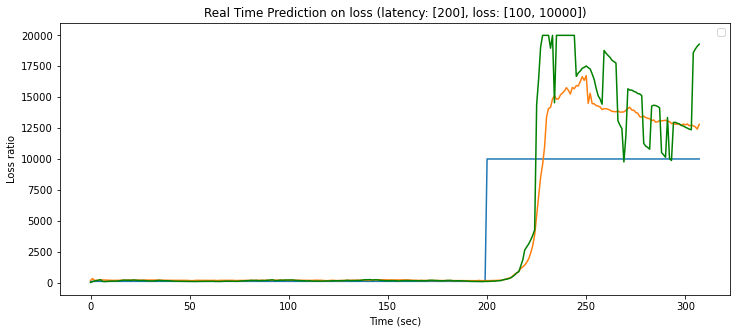

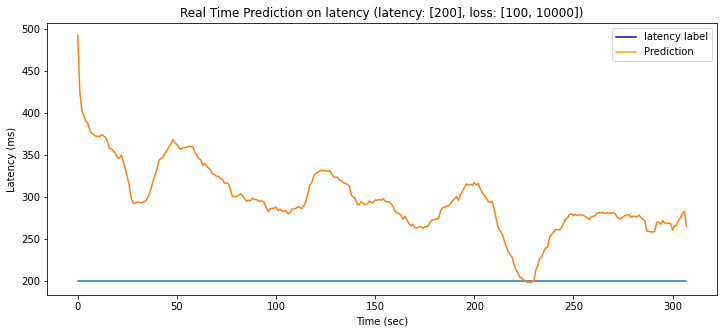

In [34]:
def gen_model(label, n_jobs=-1, train_window=20, pca_components=4, test_size=0.005):
    """generates predictive model and outputs predictions to new column in input df"""
    # other parameters:
    max_depth = 7       # see ext tree regressor
    cv = 5              # see grid search cv
    threshold = 0.15    # pct error margin threshold
    
    if label == "loss":
        # loss features
        indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
    elif label == "latency":
        # latency features
        indexcol = [
            "total_pkts",
            "total_pkt_sizes",
            "2->1Bytes",
            "number_ms",
            "mean_tdelta",
            "max_tdelta",
            "time_spread",
            "longest_seq",
        ]

    ## takes transformed datababy from outputs (should be in gdrive)
    ct = pd.read_csv(f"outputs/combined_transform_{train_window}.csv")

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], 
        ct[label], 
        test_size=test_size, random_state=2020
    )

    pipe = Pipeline(steps=[
        ('reduce_dim', PCA(pca_components)), 
        ('clf', ExtraTreesRegressor(max_depth=max_depth, n_jobs=n_jobs))])
    param_grid = [{'clf' : [ExtraTreesRegressor(max_depth=max_depth, n_jobs=n_jobs)],
                   'clf__n_estimators' : list(range(80,180,30))}
    ]
    mdl = GridSearchCV(pipe, param_grid=param_grid, cv=cv, verbose=False, n_jobs=n_jobs)

    # pipe = Pipeline(steps=[
    #     ('reduce_dim', PCA(4)), 
    #     ('clf', KNeighborsRegressor())])
    # param_grid = [{'clf' : [KNeighborsRegressor()],
    #                'clf__n_neighbors' : list(range(1,10))}
    # ]
    # mdl = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

    mdl = mdl.fit(X_train, y_train)
    
    print(f"----------{label} model test set statistics----------")
    print(f"{label} model validation MAPE:", mean_absolute_percentage_error(mdl.predict(X_test), y_test))
    print(f"{label} model validation Median Absolute Error:", median_absolute_error(mdl.predict(X_test), y_test))
    print(f"{label} model validation pct of predictions within {threshold} margin:", pct_err_correct(mdl.predict(X_test), y_test, threshold=threshold))

    print("R2 Score:", mdl.score(X_test, y_test))
    
    # TODO save model with pickling
    return mdl

def emp_loss(df, window=25, upperlimit=20000):
    """
    helper function that returns empirical loss of a dataframe with the provided data over a specified window of time.
    empirical loss is defined as the total count of packet drops divided by the total number of packets.
    
    works with dataframe outputs from readfilerun/readfilerunsimple
    
    upper limit is set to default at a maximum of 20000 for visualizations
    """
    
    eloss =  (
        df["total_pkts"].rolling(window, min_periods=1).sum()
        / df["event"]
        .str.replace("switch", "")
        .str.split(";")
        .str.len()
        .fillna(0)
        .rolling(window, min_periods=1)
        .sum()
    )
    eloss.replace([np.inf, -np.inf], upperlimit, inplace=True)
    eloss[eloss > upperlimit] = upperlimit
    return eloss.bfill().ffill()

def vis_model(df, label, mdl, classify=False, threshold=-0.15, window=20, emplosswindow=25, pct_change_window=2):
    '''generates visualizations of model performance, works in conjunction with gen_model()'''
    
    # other parameters
    smooth_window = 10
    pcterr_thresh = 0.15
    lat_threshold = 0.06
    if label == "loss":
        # loss features
        indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
    elif label == "latency":
        # latency features
        indexcol = [
            "total_pkts",
            "total_pkt_sizes",
            "2->1Bytes",
            "number_ms",
            "mean_tdelta",
            "max_tdelta",
            "time_spread",
            "longest_seq",
        ]
        
    df["prediction"] = mdl.predict(
        df[indexcol].rolling(window).mean().bfill()
    )
        
    df[f"pred_{label}"] = mdl.predict(df.rolling(window, min_periods=1)[indexcol].mean()) # prediction on mean aggregation

    print(f"-----{label} model test input dataframe statistics (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})-----")
    test_mape = mean_absolute_percentage_error(mdl.predict(df[indexcol]), df[label])
    test_mederr = median_absolute_error(mdl.predict(df[indexcol]), df[label])
    test_pcterr = pct_err_correct(mdl.predict(df[indexcol]), df[label], threshold=pcterr_thresh)
    print(f"test dataframe {label} prediction MAPE:", test_mape)
    print(f"test dataframe {label} prediction Median Absolute Error:", test_mederr)
    print(f"test dataframe {label} prediction within pct err threshold of {pcterr_thresh}:", test_pcterr)

    ## plotting performance visual
    # fig = plt.figure()
    
    if label == 'latency':
        ylabel = 'Latency (ms)'
    if label == 'loss':
        ylabel = 'Loss ratio'
    df[[label, f"pred_{label}"]].plot(
        figsize=(12, 5),
        title=f"Real Time Prediction on {label} (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})",
        xlabel="Time (sec)",
        ylabel=ylabel,
    )
    if label == "loss":
        eloss = emp_loss(df, emplosswindow)
        eloss.plot(color='green')
        test_mape_eloss = mean_absolute_percentage_error(mdl.predict(df[indexcol]), eloss)
        test_pcterr_eloss = pct_err_correct(mdl.predict(df[indexcol]), eloss, threshold=pcterr_thresh)
        print("test dataframe MAPE w/ emp loss:", test_mape_eloss)
        print(f"test dataframe {label} prediction w/ emp loss within pct err threshold of {pcterr_thresh}:", test_pcterr_eloss)

    if label == "loss":
        plt.legend(
            [
                f"{label} label",
                "Prediction",
                f"Empirical Loss (window {emplosswindow} sec)",
                ''
            ],
            loc="upper right",
        )
    else:
        plt.legend(
            [
                f"{label} label",
                "Prediction",
            ],
            loc="center left",
        )
        test_mape_eloss = np.nan
        test_pcterr_eloss = np.nan
    # for i in df[~df["event"].isnull()].index:
    #     plt.axvline(x=i, color="y", alpha=0.45)

    ## adds new column to df
    
    df[f'pred_{label}_pctc2_smooth'] = df[f'pred_{label}'].rolling(smooth_window, min_periods=1).mean().pct_change(pct_change_window).rolling(smooth_window, min_periods=1).mean()
    
    if classify:
        anomaly_idx = df[df[f'pred_{label}_pctc2_smooth'] <= threshold].index - window
        for i in anomaly_idx[anomaly_idx > 0]: # indices where negative percent change is higher than threshold
            plt.axvline(x=i, color='r', alpha=.45)
    idx = f"latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())}"
    return (idx, test_mape, test_pcterr, test_mape_eloss, test_pcterr_eloss, test_mederr)
def vis_model(df, label, mdl, classify=False, threshold=-0.15, window=20, emplosswindow=25, pct_change_window=2, verbose=True):
    '''generates visualizations and evaluations of model performance
    works in conjunction with gen_model() and run inside performance_metrics()'''
    
    # other parameters
    smooth_window = 10
    pcterr_thresh = 0.15
    lat_threshold = 0.06
    
    if label == "loss":
        # loss features
        indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
    elif label == "latency":
        # latency features
        indexcol = [
            "total_pkts",
            "total_pkt_sizes",
            "2->1Bytes",
            "number_ms",
            "mean_tdelta",
            "max_tdelta",
            "time_spread",
            "longest_seq",
        ]
        
    df[f"pred_{label}"] = mdl.predict(df.rolling(window, min_periods=1)[indexcol].mean()) # prediction on mean aggregation

    test_mape = mean_absolute_percentage_error(mdl.predict(df[indexcol]), df[label])
    test_mederr = median_absolute_error(mdl.predict(df[indexcol]), df[label])
    test_pcterr = pct_err_correct(mdl.predict(df[indexcol]), df[label], threshold=pcterr_thresh)
    if verbose:
        print(f"-----{label} model test input dataframe statistics (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})-----")
        print(f"test dataframe {label} prediction MAPE:", test_mape)
        print(f"test dataframe {label} prediction Median Absolute Error:", test_mederr)
        print(f"test dataframe {label} prediction within pct err threshold of {pcterr_thresh}:", test_pcterr)

    ## plotting performance visual
    if label == 'latency':
        ylabel = 'Latency (ms)'
    if label == 'loss':
        ylabel = 'Loss ratio'
        
    df[[label, f"pred_{label}"]].plot(
        figsize=(12, 5),
        title=f"Real Time Prediction on {label} (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})",
        xlabel="Time (sec)",
        ylabel=ylabel,
    )
    
    # vertical line for legends below
    vertical_line = Line2D([], [], color='red', marker='|', linestyle='None', alpha=.45,
                    markersize=10, markeredgewidth=1.5, label='Vertical line')
    
    if label == "loss":
        # empirical loss calculation
        eloss = emp_loss(df, emplosswindow)
        eloss.plot(color='green')
        test_mape_eloss = mean_absolute_percentage_error(mdl.predict(df[indexcol]), eloss)
        test_pcterr_eloss = pct_err_correct(mdl.predict(df[indexcol]), eloss, threshold=pcterr_thresh)
        print("test dataframe MAPE w/ emp loss:", test_mape_eloss)
        print(f"test dataframe {label} prediction w/ emp loss within pct err threshold of {pcterr_thresh}:", test_pcterr_eloss)
        
        # plot legend
        lines = [
                Line2D([0], [0], color='tab:blue'),
                Line2D([0], [0], color='tab:orange'), 
                Line2D([0], [0], color='tab:green'), 
                vertical_line
                ],
        labels = [
                f"{label} label",
                "Prediction",
                f"Empirical Loss",
                "Percent Change Anomaly"
            ]
        
    else:
        test_mape_eloss = np.nan
        test_pcterr_eloss = np.nan
        # latency plot legend
        lines = [
            Line2D([0], [0], color='blue'),
            Line2D([0], [0], color='orange'),
            vertical_line
        ]
        labels = [
            f"{label} label",
            "Prediction",
            "Percent Change Anomaly"
        ]
    plt.legend(lines, labels, loc="upper right") if classify else plt.legend(lines[:-1], labels[:-1], loc="upper right")
    
    df[f'pred_{label}_pctc2_smooth'] = (
        df[f'pred_{label}'].rolling(smooth_window, min_periods=1).mean()
        ).pct_change(pct_change_window).rolling(smooth_window, min_periods=1).mean()
    
    # if classify:
    #     if label == 'loss':
    #         anomaly_idx = df[df[f'pred_{label}_pctc2_smooth'] <= threshold].index - window
    #         for i in anomaly_idx[anomaly_idx > 0]: # indices where negative percent change is higher than threshold
    #             plt.axvline(x=i, color='r', alpha=.45)
    #     else:
    #         anomaly_idx = df[df[f'pred_{label}_pctc2_smooth'] >= lat_threshold].index - window 
    #         for i in anomaly_idx[anomaly_idx > 0]: # indices where negative percent change is higher than threshold
    #             plt.axvline(x=i, color='r', alpha=.45)
    anomalies = df[f'pred_{label}_pctc2_smooth'] <= threshold
    if classify:
        if label == 'loss':
            anomalies = df[f'pred_{label}_pctc2_smooth'] <= threshold
            anomaly_idx = df[anomalies].index - (window// 2)
            for i in anomaly_idx[anomaly_idx > 0]: # indices where *negative* percent change is higher than threshold
                plt.axvline(x=i, color='r', alpha=.45)
        elif label == 'latency':
            anomalies = df[f'pred_{label}_pctc2_smooth'] >= threshold
            anomaly_idx = df[anomalies].index - (window // 2) 
            for i in anomaly_idx[anomaly_idx > 0]: # indices where percent change is greater than threshold
                plt.axvline(x=i, color='r', alpha=.45)
    idx = f"latency_{str(list(df['latency'].unique())).strip('[]').replace(', ', '-')}_loss_{str(list(df['loss'].unique())).strip('[]').replace(', ', '-')}"
    
    predictions = os.path.join("out/anomaly_detection", f'{label}_anomalies_with_{idx}.csv')
    print(pd.Series(anomalies).value_counts())
    
    saveto = os.path.join("outputs/model", f'{label}_performance_{idx}.png')
    plt.savefig(saveto)
    return anomalies, df['Time']
    # return (idx, test_mape, test_pcterr, test_mape_eloss, test_pcterr_eloss, test_mederr)

# lossmodel = gen_model("loss")
# latmodel = gen_model("latency")
vis_model(df, "loss", lossmodel)
vis_model(df, "latency", latmodel)

In [33]:
e.unique()

array([nan], dtype=object)

In [49]:
pd.DataFrame({'Time':f, 'Anomalies':e})

,Time,Anomalies
0,1643677660,False
1,1643677661,False
2,1643677662,False
4,1643677663,False
5,1643677664,False
...,...,...
303,1643677957,False
304,1643677958,False
305,1643677959,False
306,1643677960,False


-----loss model test input dataframe statistics (latency: [200], loss: [100, 10000])-----
test dataframe loss prediction MAPE: 1.2496677160391565
test dataframe loss prediction Median Absolute Error: 128.23139367345942
test dataframe loss prediction within pct err threshold of 0.15: 0.04304635761589404
test dataframe MAPE w/ emp loss: 0.2891595906892676
test dataframe loss prediction w/ emp loss within pct err threshold of 0.15: 0.3211920529801324
False    302
Name: pred_loss_pctc2_smooth, dtype: int64


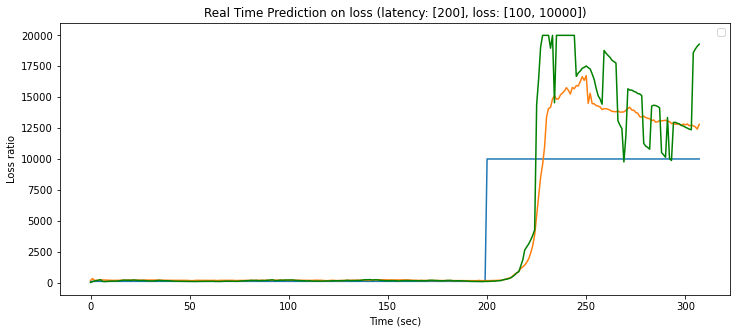

In [35]:
e, f = vis_model(df, "loss", lossmodel)

-----loss model test input dataframe statistics (latency: [50], loss: [500, 50])-----
test dataframe loss prediction MAPE: 0.694627539629911
test dataframe loss prediction Median Absolute Error: 503.67004528432017
test dataframe loss prediction within pct err threshold of 0.15: 0.01607717041800643
test dataframe MAPE w/ emp loss: 0.5679128114667418
test dataframe loss prediction w/ emp loss within pct err threshold of 0.15: 0.05787781350482315
False    287
True      24
Name: pred_loss_pctc2_smooth, dtype: int64
-----latency model test input dataframe statistics (latency: [50], loss: [500, 50])-----
test dataframe latency prediction MAPE: 0.7566511142475756
test dataframe latency prediction Median Absolute Error: 153.01957550266962
test dataframe latency prediction within pct err threshold of 0.15: 0.0
False    307
True       4
Name: pred_latency_pctc2_smooth, dtype: int64
-----loss model test input dataframe statistics (latency: [400], loss: [1000, 100])-----
test dataframe loss predic

(                             test_mape  test_pcterr  test_mape_eloss  \
 idx                                                                    
 latency_50_loss_500-50        0.694628     0.016077         0.567913   
 latency_400_loss_1000-100     0.610134     0.121739         1.468623   
 latency_50_loss_10000-1000    0.625599     0.022801         0.617124   
 latency_400_loss_10000-1000   1.063004     0.289902         1.625113   
 latency_400_loss_500-50       0.540684     0.127168         1.223524   
 latency_50_loss_1000-100      0.722967     0.012579         0.617408   
 
                              test_pcterr_eloss  test_mederr  
 idx                                                          
 latency_50_loss_500-50                0.057878   503.670045  
 latency_400_loss_1000-100             0.171014   187.544274  
 latency_50_loss_10000-1000            0.462541  6061.750351  
 latency_400_loss_10000-1000           0.257329  1141.884100  
 latency_400_loss_500-50            

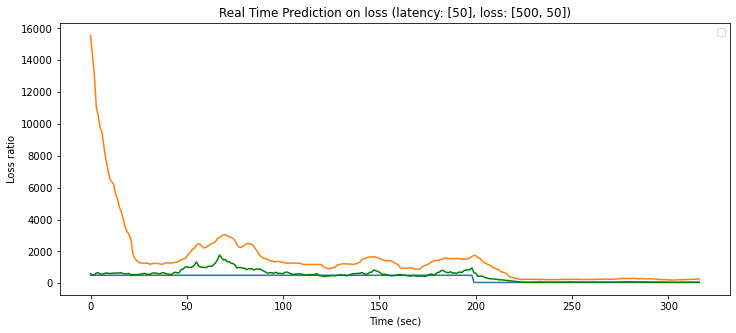

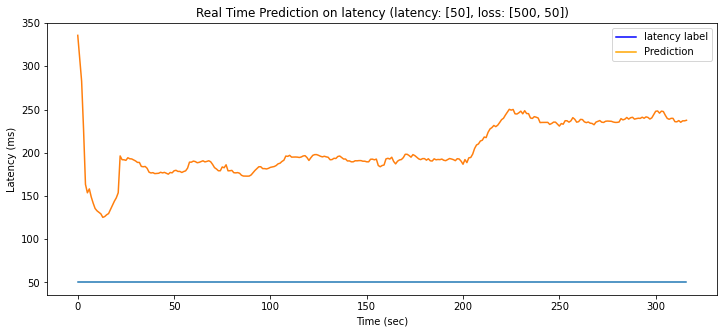

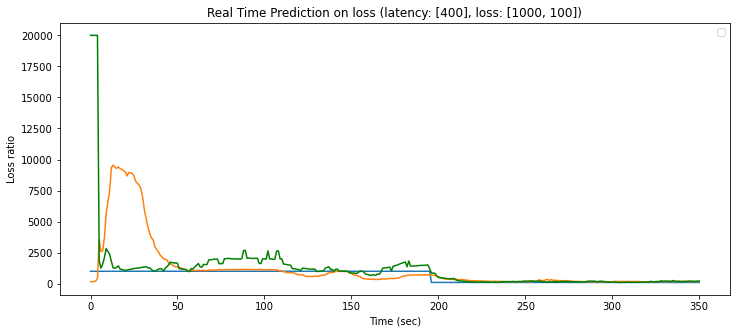

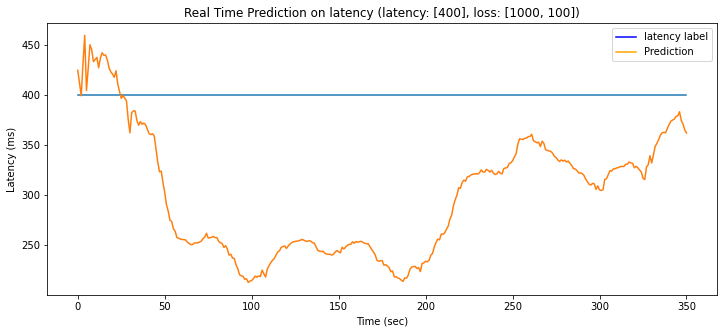

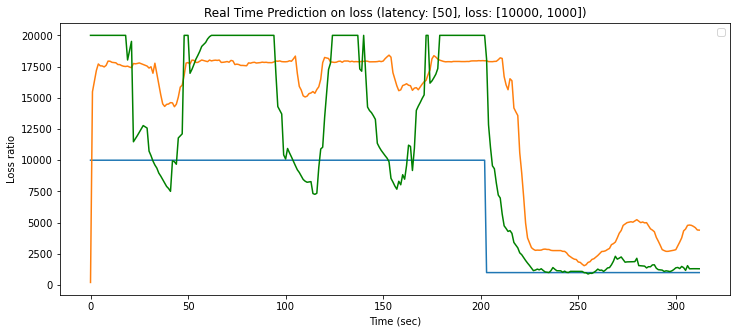

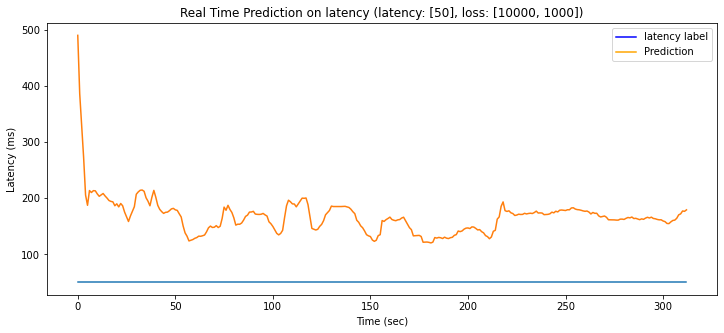

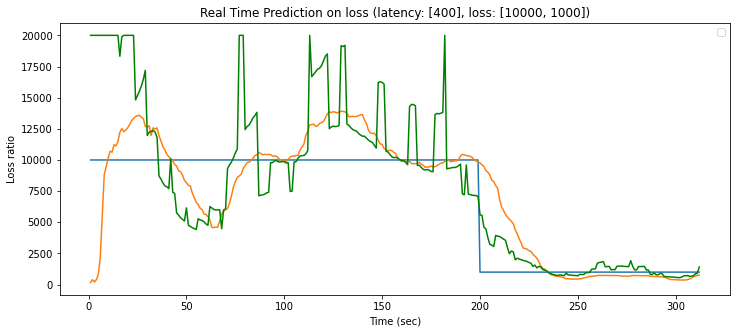

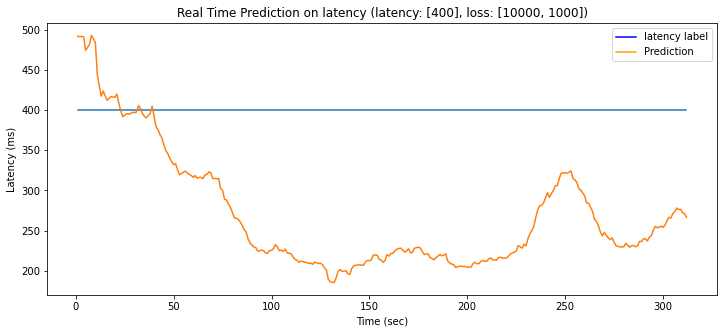

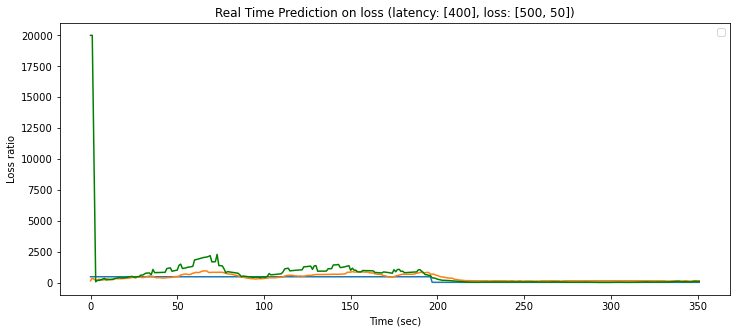

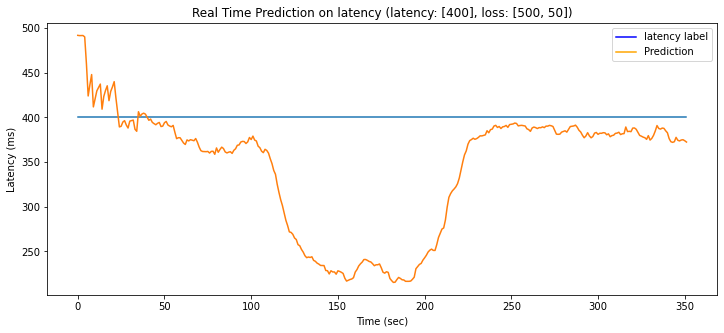

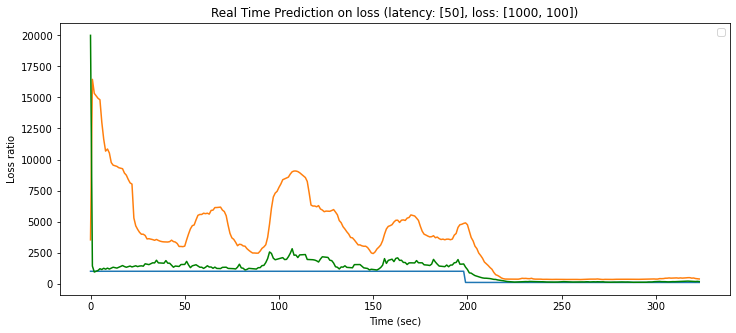

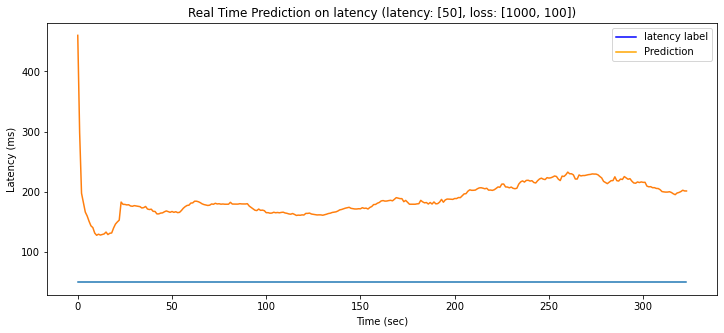

In [25]:
def get_statistics(filedir, classify=False):
    # dir_ = 'data/jennawk5data'
    losslst = []
    latencylst = []
    for i in [x for x in listdir(filedir) if not 'losslog' in x]:
        # the_csv_youre_using = listdir(dir_)

        mergedtable = readfilerun_simple(os.path.join(filedir, i), filedir) # merges losslog. make sure you have losslog in the same train_c directory
        df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
        losslst.append(vis_model(df_, "loss", lossmodel, classify))
        latencylst.append(vis_model(df_, "latency", latmodel, classify))
    print(losslst, latencylst)
    # return (pd.DataFrame(losslst, columns=['idx', 'test_mape', 'test_pcterr', 'test_mape_eloss', 'test_pcterr_eloss', 'test_mederr']).set_index('idx'), 
    #         pd.DataFrame(latencylst, columns=['idx', 'test_mape', 'test_pcterr', 'test_mape_eloss', 'test_pcterr_eloss', 'test_mederr']).set_index('idx'))
    return losslst()
blah = get_statistics('data/jenna_week8_data')
blah

-----loss model test input dataframe statistics (latency: [50], loss: [500, 50])-----
test dataframe loss prediction MAPE: 0.7091869088684486
test dataframe loss prediction Median Absolute Error: 573.8061201521791
test dataframe loss prediction within pct err threshold of 0.15: 0.022508038585209004
test dataframe MAPE w/ emp loss: 0.5871991817821773
test dataframe loss prediction w/ emp loss within pct err threshold of 0.15: 0.03536977491961415
-----latency model test input dataframe statistics (latency: [50], loss: [500, 50])-----
test dataframe latency prediction MAPE: 0.755303444250342
test dataframe latency prediction Median Absolute Error: 149.74571968184156
test dataframe latency prediction within pct err threshold of 0.15: 0.0
-----loss model test input dataframe statistics (latency: [400], loss: [1000, 100])-----
test dataframe loss prediction MAPE: 0.5332300484590796
test dataframe loss prediction Median Absolute Error: 164.37153489250022
test dataframe loss prediction within 

(                             test_mape  test_pcterr  test_mape_eloss  \
 idx                                                                    
 latency_50_loss_500-50        0.709187     0.022508         0.587199   
 latency_400_loss_1000-100     0.533230     0.136232         1.152914   
 latency_50_loss_10000-1000    0.630670     0.022801         0.619090   
 latency_400_loss_10000-1000   0.758081     0.306189         1.060072   
 latency_400_loss_500-50       0.512218     0.121387         0.881309   
 latency_50_loss_1000-100      0.741432     0.015723         0.631182   
 
                              test_pcterr_eloss  test_mederr  
 idx                                                          
 latency_50_loss_500-50                0.035370   573.806120  
 latency_400_loss_1000-100             0.200000   164.371535  
 latency_50_loss_10000-1000            0.442997  6212.268164  
 latency_400_loss_10000-1000           0.276873  1166.836999  
 latency_400_loss_500-50            

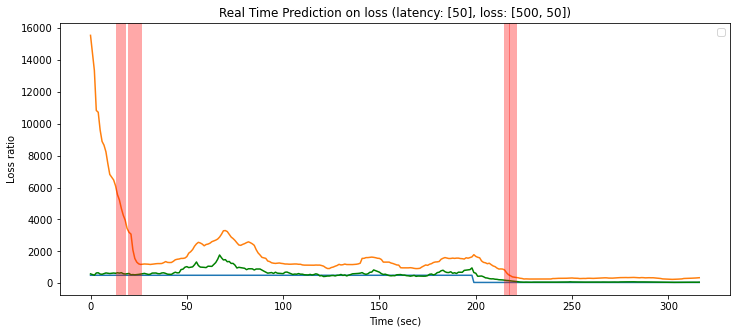

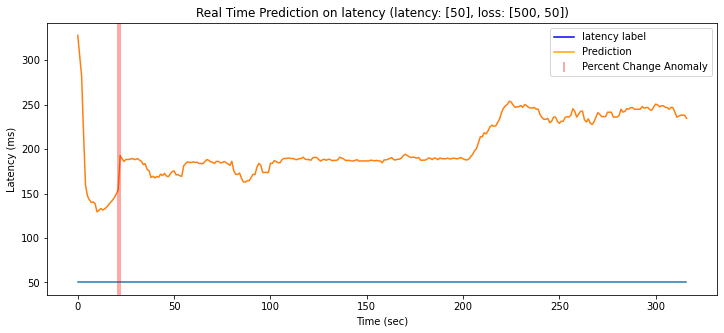

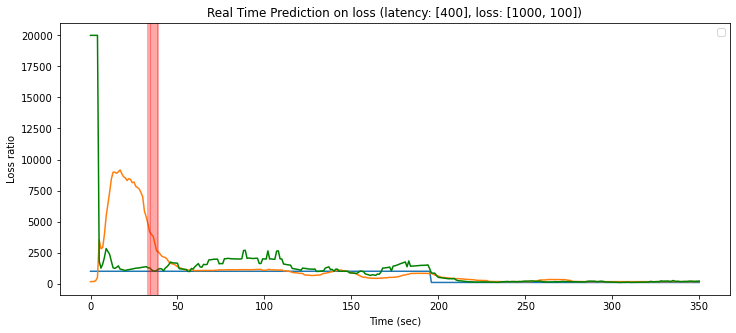

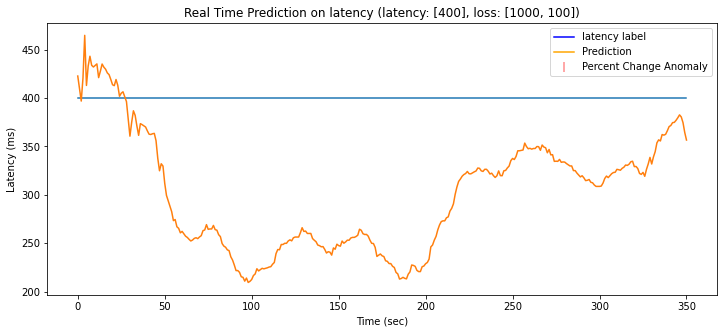

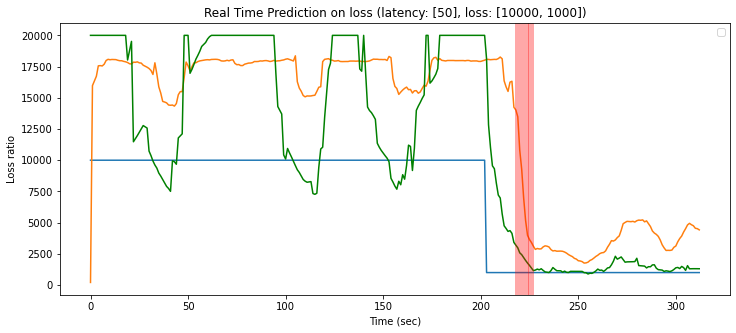

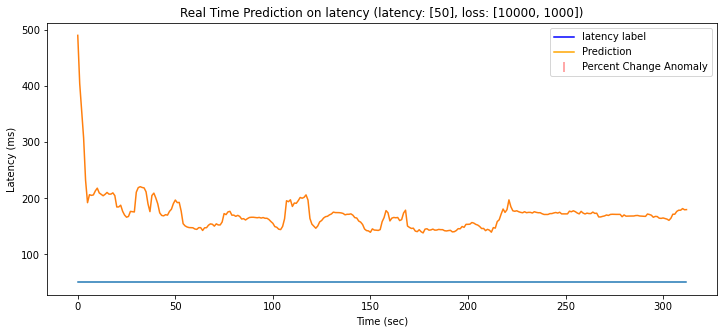

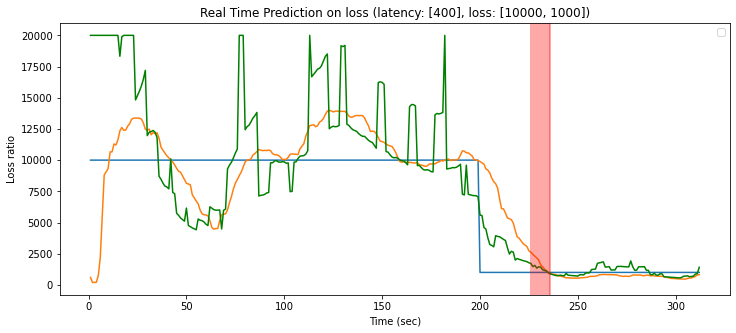

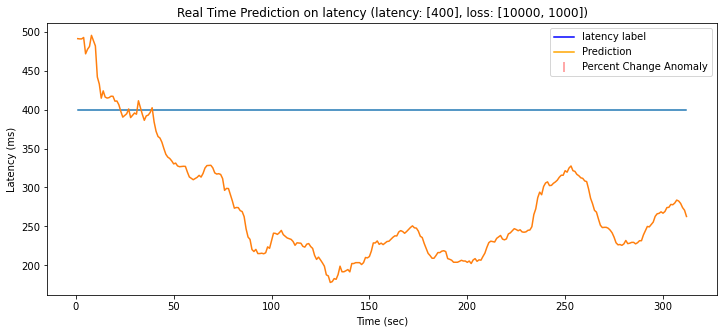

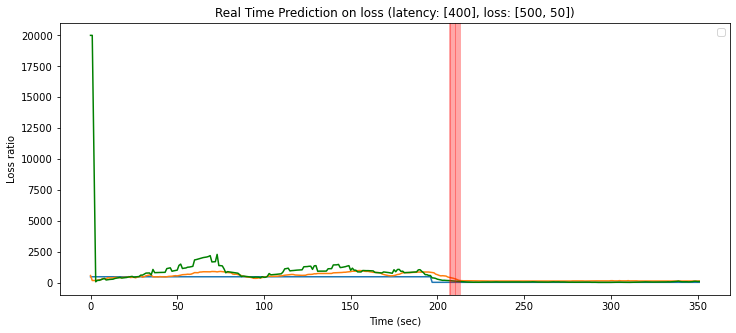

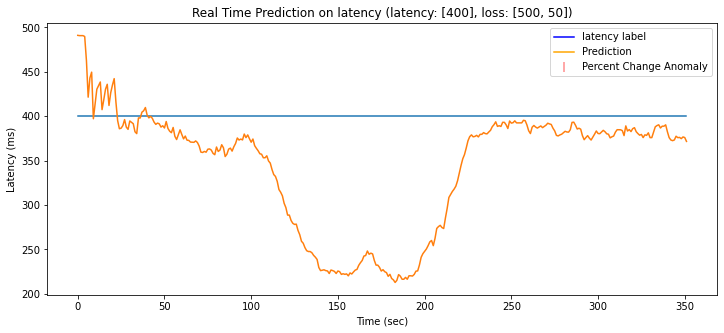

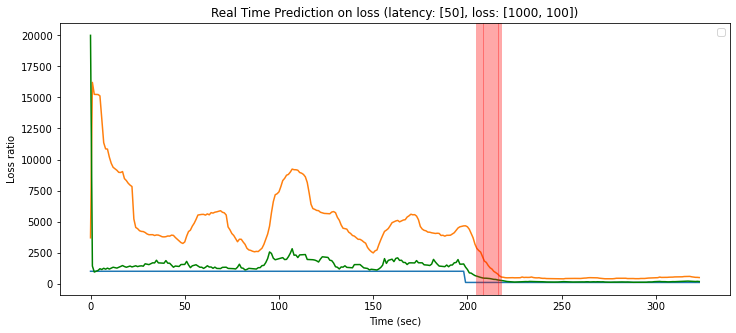

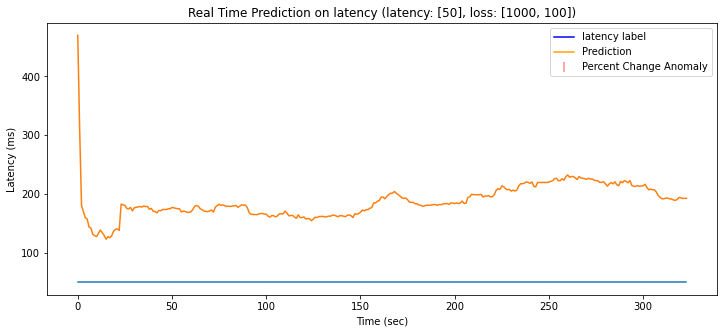

In [20]:
get_statistics('data/jenna_week8_data', classify=True)

In [ ]:
blah[0]

,test_mape,test_pcterr,test_mape_eloss,test_pcterr_eloss,test_mederr
idx,,,,,
"latency: [50], loss: [500, 50]",0.686440,0.016077,0.555801,0.051447,512.176577
"latency: [400], loss: [1000, 100]",0.563154,0.150725,1.491086,0.237681,123.938625
"latency: [50], loss: [10000, 1000]",0.606820,0.039088,0.574342,0.446254,6191.300445
"latency: [400], loss: [10000, 1000]",1.072886,0.302932,1.631853,0.270358,1201.264785
"latency: [400], loss: [500, 50]",0.525845,0.106936,1.159338,0.121387,120.013573
"latency: [50], loss: [1000, 100]",0.723197,0.015723,0.622198,0.018868,1873.529085


In [ ]:
blah[1]

,test_mape,test_pcterr,test_mape_eloss,test_pcterr_eloss,test_mederr
idx,,,,,
"latency: [50], loss: [500, 50]",0.760694,0.000000,NaN,NaN,153.390646
"latency: [400], loss: [1000, 100]",0.399230,0.243478,NaN,NaN,99.484523
"latency: [50], loss: [10000, 1000]",0.720486,0.000000,NaN,NaN,130.657407
"latency: [400], loss: [10000, 1000]",0.654854,0.143322,NaN,NaN,150.591898
"latency: [400], loss: [500, 50]",0.251953,0.641618,NaN,NaN,38.472463
"latency: [50], loss: [1000, 100]",0.743943,0.000000,NaN,NaN,144.481985


In [ ]:
blah[0]

,test_mape,test_pcterr,test_mape_eloss,test_pcterr_eloss,test_mederr
idx,,,,,
"latency: [50], loss: [500, 50]",0.686440,0.016077,0.555801,0.051447,512.176577
"latency: [400], loss: [1000, 100]",0.563154,0.150725,1.491086,0.237681,123.938625
"latency: [50], loss: [10000, 1000]",0.606820,0.039088,0.574342,0.446254,6191.300445
"latency: [400], loss: [10000, 1000]",1.072886,0.302932,1.631853,0.270358,1201.264785
"latency: [400], loss: [500, 50]",0.525845,0.106936,1.159338,0.121387,120.013573
"latency: [50], loss: [1000, 100]",0.723197,0.015723,0.622198,0.018868,1873.529085


In [ ]:
blah[0].mean()

test_mape               0.696390
test_pcterr             0.105247
test_mape_eloss         1.005770
test_pcterr_eloss       0.190999
test_mederr          1670.370515
dtype: float64

In [ ]:
blah[1].mean()

test_mape              0.588527
test_pcterr            0.171403
test_mape_eloss             NaN
test_pcterr_eloss           NaN
test_mederr          119.513154
dtype: float64

In [ ]:
blah[1]

,test_mape,test_pcterr,test_mape_eloss,test_pcterr_eloss,test_mederr
idx,,,,,
"latency: [50], loss: [500, 50]",0.760694,0.000000,NaN,NaN,153.390646
"latency: [400], loss: [1000, 100]",0.399230,0.243478,NaN,NaN,99.484523
"latency: [50], loss: [10000, 1000]",0.720486,0.000000,NaN,NaN,130.657407
"latency: [400], loss: [10000, 1000]",0.654854,0.143322,NaN,NaN,150.591898
"latency: [400], loss: [500, 50]",0.251953,0.641618,NaN,NaN,38.472463
"latency: [50], loss: [1000, 100]",0.743943,0.000000,NaN,NaN,144.481985


In [ ]:
latmodel.best_estimator_['clf'].feature_importances_

array([0.04367617, 0.52999361, 0.25021775, 0.17611247])

In [ ]:
latmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=4)),
                ('clf',
                 ExtraTreesRegressor(max_depth=7, n_estimators=140,
                                     n_jobs=-1))])

In [ ]:
lossmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=4)),
                ('clf',
                 ExtraTreesRegressor(max_depth=7, n_estimators=140,
                                     n_jobs=-1))])

In [ ]:
lossmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=4)),
                ('clf',
                 ExtraTreesRegressor(max_depth=7, n_estimators=140,
                                     n_jobs=-1))])

In [ ]:
df[['loss', 'latency', 'pred_loss', 'pred_latency']]

,loss,latency,pred_loss,pred_latency
0,100,200,161.295033,490.811303
1,100,200,193.216761,416.659569
2,100,200,154.202779,397.638331
4,100,200,147.743407,381.814585
5,100,200,152.705206,378.782902
...,...,...,...,...
303,10000,200,12402.572150,273.915847
304,10000,200,12296.552113,276.894993
305,10000,200,12358.452653,281.138888
306,10000,200,12332.502618,281.882982


In [ ]:

def plotfeatures(filedir, feature='mean_tdelta'):
    # dir_ = 'data/jennawk5data'
    losslst = []
    latencylst = []
    for i in [x for x in listdir(filedir) if not 'losslog' in x]:
        # the_csv_youre_using = listdir(dir_)

        mergedtable = readfilerun_simple(os.path.join(filedir, i), filedir) # merges losslog. make sure you have losslog in the same train_c directory
        df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
        # df[feature].plot(
        # figsize=(12, 5),
        # title=f"{feature} plot over Time (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})",
        # xlabel="Time (sec)",
        # ylabel=feature,
        #)
        # plot_detailed_bytes(df_, col=feature)
plotfeatures('data\\jenna_week8_data')

In [ ]:
import seaborn as sns

In [ ]:
df

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_loss_pctc2_smooth,pred_latency,pred_latency_pctc2_smooth
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,1,13724,1143.666667,0,1143.666667,350.317351,161.295033,NaN,490.811303,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,8,52520,875.333333,808,875.333333,350.317351,193.216761,NaN,416.659569,NaN
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,9,43456,776.000000,407,776.000000,350.317351,154.202779,0.051313,397.638331,-0.113638
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,11,64196,987.630769,810,987.630769,350.317351,147.743407,-0.011413,381.814585,-0.092087
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,7,42728,1017.333333,405,1017.333333,350.317351,152.705206,-0.022821,378.782902,-0.078168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,243,1831732,1096.189108,974,1096.189108,273.915847,12402.572150,-0.004657,273.915847,0.002256
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,199,1598288,1087.270748,993,1087.270748,276.894993,12296.552113,-0.005113,276.894993,0.003105
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,223,2189224,1093.518482,987,1093.518482,281.138888,12358.452653,-0.005407,281.138888,0.004031
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,210,1907884,1077.291925,982,1077.291925,281.882982,12332.502618,-0.005413,281.882982,0.004923


In [ ]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

plot_main4() executed


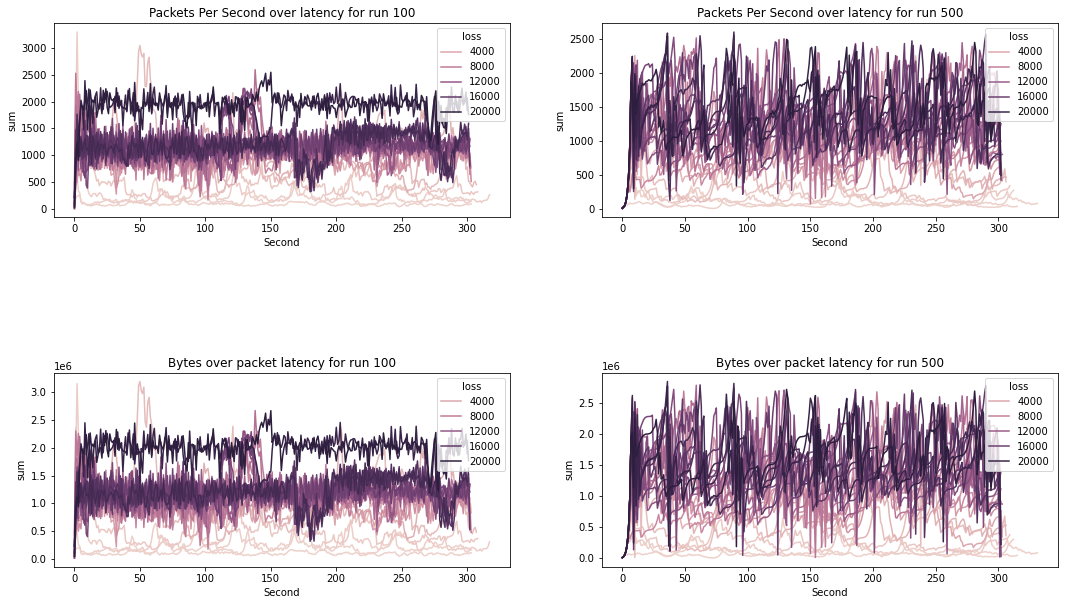

In [ ]:
filen1 = "combined_all.csv"
unseen = ''
fpath1 = os.path.join(os.getcwd() , "outputs", unseen + filen1)
df_1 = pd.read_csv(fpath1)
df200, df300 = plottogether('seen', [100, 500], df_1, filen1.strip(".csv"))

In [ ]:
df200.columns

Index(['Unnamed: 0', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto',
       '1->2Bytes', '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times',
       'packet_sizes', 'packet_dirs', 'event', 'drop_unix', 'latency', 'loss',
       'later_latency', 'later_loss', 'deterministic', 'switch_label',
       'total_bytes', 'total_pkts', 'pkt sum', 'longest_seq', 'mean_tdelta',
       'max_tdelta', 'number_ms', 'total_pkt_sizes', 'pkt_ratio',
       'time_spread', 'byte_ratio', 'Second'],
      dtype='object')

In [ ]:
df200['latency'].unique()

array([100], dtype=int64)

In [ ]:
df200['max_tdelta']

0       202
1       129
2       125
3       123
4       122
       ... 
6983     54
6984     53
6985     52
6986     55
6987     45
Name: max_tdelta, Length: 6988, dtype: int64

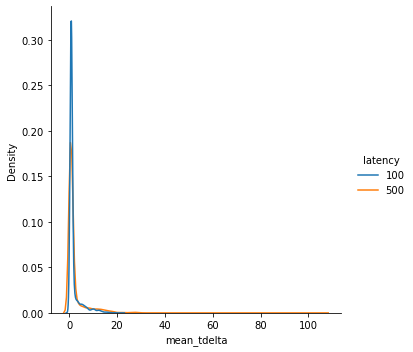

In [ ]:
colors = ['tab:blue', 'tab:orange']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.displot(pd.concat([df200, df300]), x="mean_tdelta", hue="latency", kind="kde", palette=colors)
# sns.displot(, x="max_tdelta", hue="latency", kind="kde")

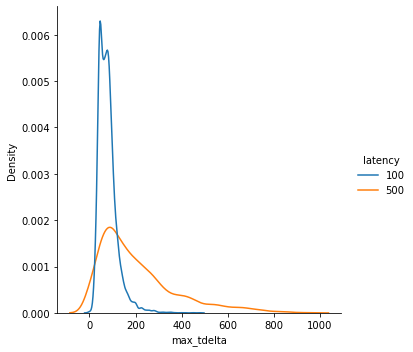

In [ ]:
colors = ['tab:blue', 'tab:orange']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.displot(pd.concat([df200, df300]), x="max_tdelta", hue="latency", kind="kde", palette=colors)
# sns.displot(, x="max_tdelta", hue="latency", kind="kde")

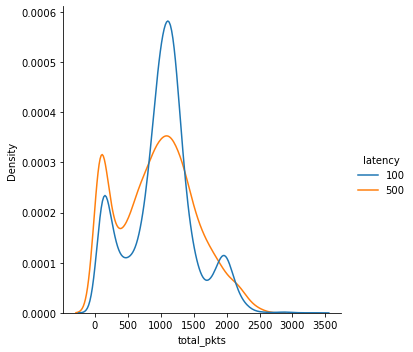

In [ ]:
colors = ['tab:blue', 'tab:orange']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.displot(pd.concat([df200, df300]), x="total_pkts", hue="latency", kind="kde", palette=colors)
# sns.displot(, x="max_tdelta", hue="latency", kind="kde")

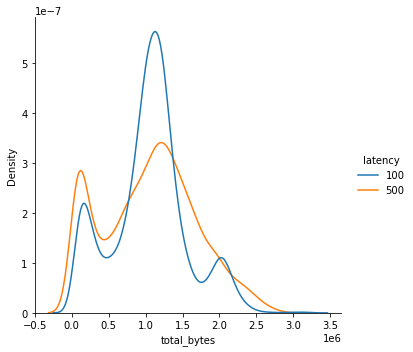

In [ ]:
colors = ['tab:blue', 'tab:orange']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.displot(pd.concat([df200, df300]), x="total_bytes", hue="latency", kind="kde", palette=colors)
# sns.displot(, x="max_tdelta", hue="latency", kind="kde")

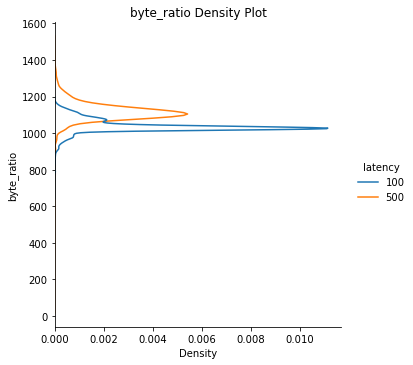

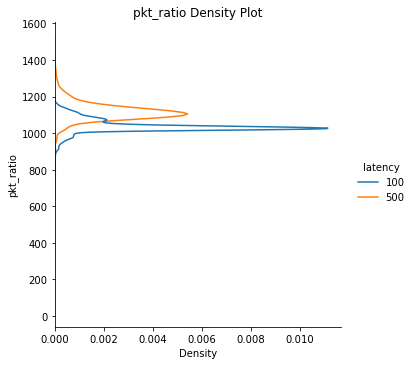

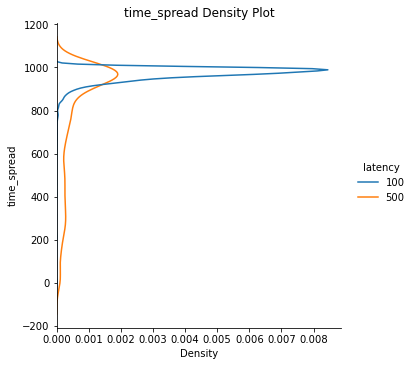

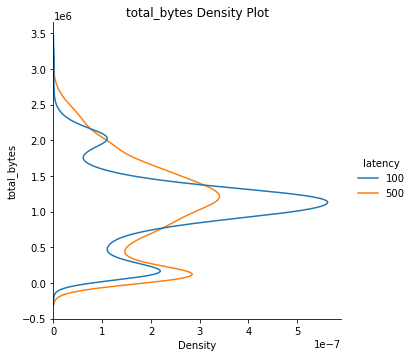

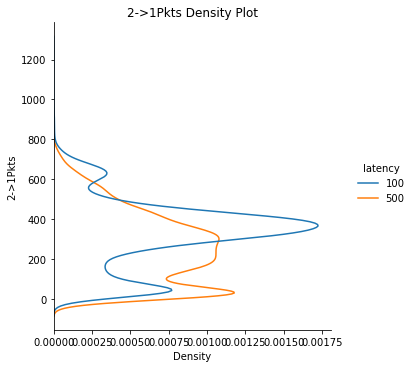

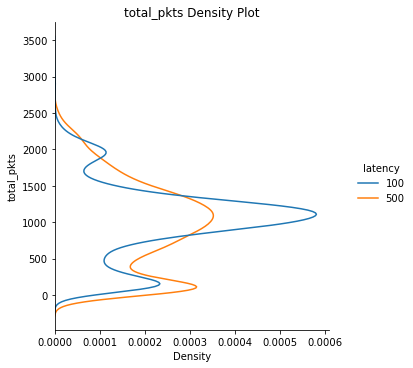

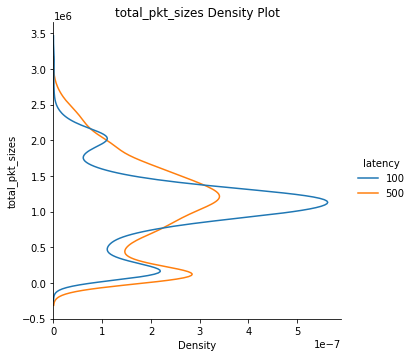

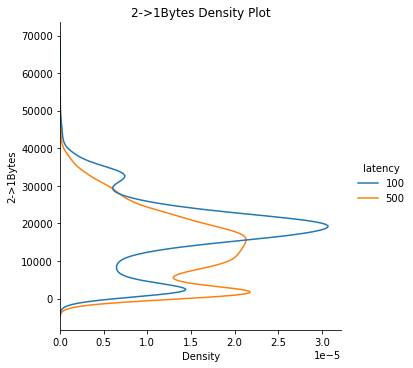

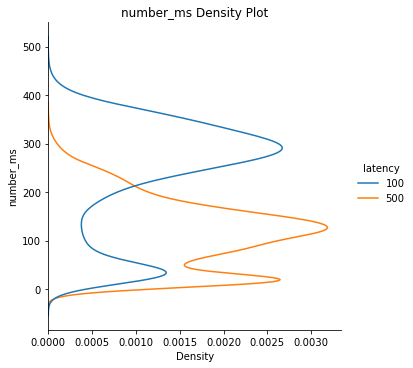

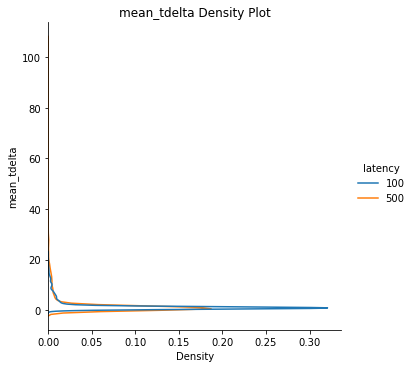

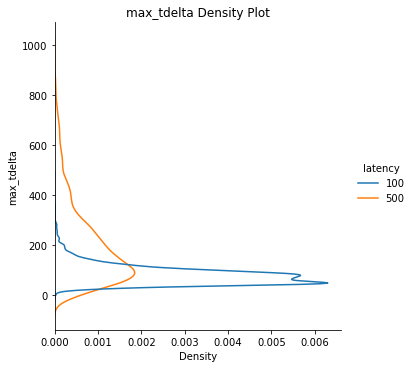

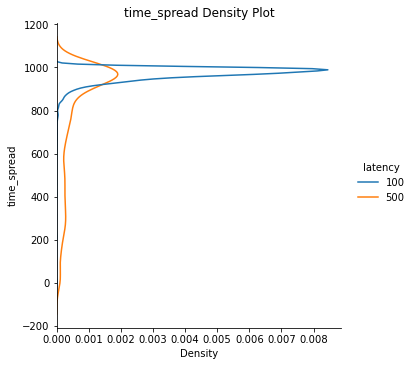

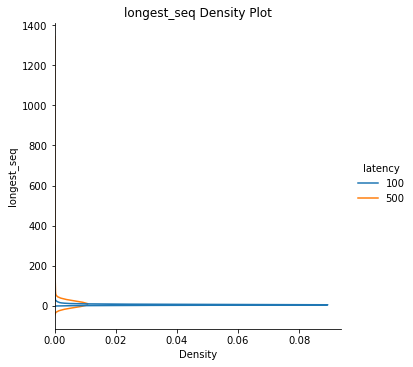

In [ ]:
featurelst = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", 
        "2->1Pkts", "total_pkts", "total_pkt_sizes", "2->1Bytes", "number_ms",
        "mean_tdelta", "max_tdelta", "time_spread", "longest_seq"]
for i in featurelst:
    colors = ['tab:blue', 'tab:orange']
    # Set your custom color palette
    sns.displot(pd.concat([df200, df300]), y=i, hue="latency", kind="kde", palette=colors).set(title=f'{i} Density Plot')
    

In [ ]:
df200[]

SyntaxError: invalid syntax (<ipython-input-123-9134a2d64de2>, line 1)

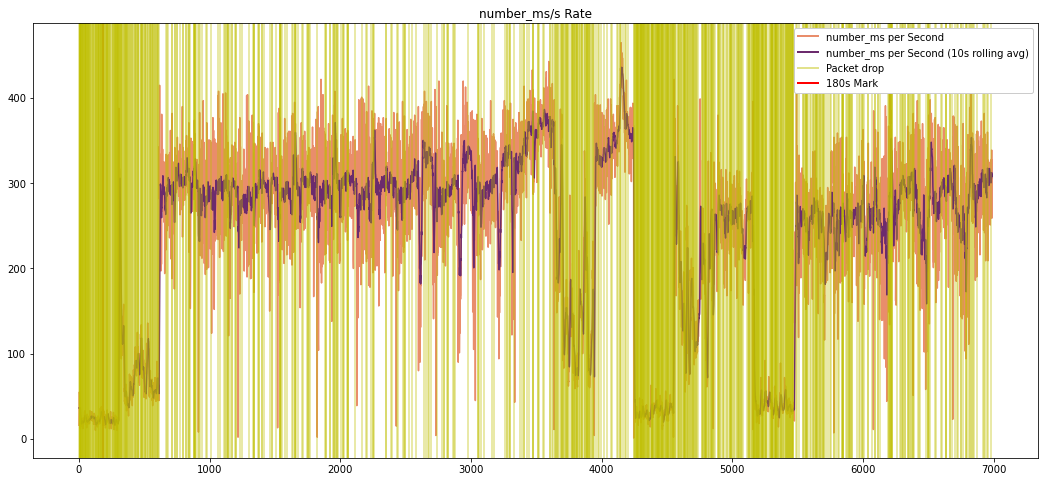

In [ ]:
plot_detailed_bytes(df200[], col='number_ms')

In [ ]:
df

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_loss_pctc2_smooth,pred_latency,pred_latency_pctc2_smooth
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,1,13724,1143.666667,0,1143.666667,350.317351,161.295033,NaN,490.811303,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,8,52520,875.333333,808,875.333333,350.317351,193.216761,NaN,416.659569,NaN
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,9,43456,776.000000,407,776.000000,350.317351,154.202779,0.051313,397.638331,-0.113638
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,11,64196,987.630769,810,987.630769,350.317351,147.743407,-0.011413,381.814585,-0.092087
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,7,42728,1017.333333,405,1017.333333,350.317351,152.705206,-0.022821,378.782902,-0.078168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,243,1831732,1096.189108,974,1096.189108,273.915847,12402.572150,-0.004657,273.915847,0.002256
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,199,1598288,1087.270748,993,1087.270748,276.894993,12296.552113,-0.005113,276.894993,0.003105
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,223,2189224,1093.518482,987,1093.518482,281.138888,12358.452653,-0.005407,281.138888,0.004031
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,210,1907884,1077.291925,982,1077.291925,281.882982,12332.502618,-0.005413,281.882982,0.004923


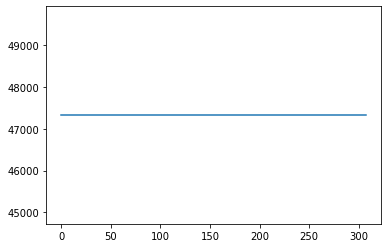

In [ ]:
ax = df['Port1'].plot()
saveto = os.path.join("outputs/model", 'performance'.replace('>', '')  + ".png")
plt.savefig(saveto)

In [ ]:
# saveto = os.path.join(path, "eda",unseen +  i.replace('>', '')  + ".png")s
str([1,2,3,4,5]).strip('[]').replace(', ', '-')


'1-2-3-4-5'

TODO: classification label inside graph legende as welll as flag inside filename saved
finishing the test target in run.py amongst others (you left off at latmodel and lossmodel)
changing and testing vismodel to work inside train.py


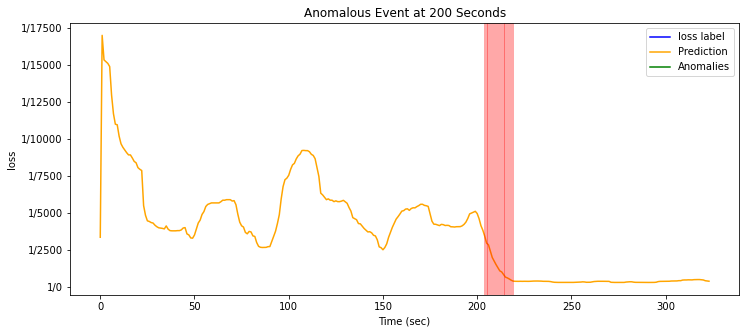

In [ ]:
# df[[label, f"pred_{label}"]].plot(
filedir = 'data\\jenna_week8_data'
for j, i in enumerate([x for x in listdir(filedir) if not 'losslog' in x]):
        # the_csv_youre_using = listdir(dir_)
    if j == 5:
        mergedtable = readfilerun_simple(os.path.join(filedir, i), filedir) # merges losslog. make sure you have losslog in the same train_c directory
        df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
        mdl = lossmodel
        label='loss'
        window=20 
        emplosswindow=25
        pct_change_window=2
        smooth_window = 10
        if label == "loss":
            # loss features
            indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
        elif label == "latency":
            # latency features
            indexcol = [
                "total_pkts",
                "total_pkt_sizes",
                "2->1Bytes",
                "number_ms",
                "mean_tdelta",
                "max_tdelta",
                "time_spread",
                "longest_seq",
            ]
        fig, ax = plt.subplots(figsize=(12, 5))
        df_[f"pred_{label}"] = mdl.predict(df_.rolling(window, min_periods=1)[indexcol].mean()) # prediction on mean aggregation
        ax = df_[f"pred_{label}"].plot(
                figsize=(12, 5),
                # title=f"Real Time Prediction on {label} (latency: {list(df['latency'].unique())}, loss: {list(df['loss'].unique())})",
                title=f"Anomalous Event at 200 Seconds",
                xlabel="Time (sec)",
                ylabel=label,
                color='orange'
            )
        # if label == "loss":
        #     eloss = emp_loss(df, emplosswindow)
        #     eloss.plot(color='green')
        #     test_mape_eloss = mean_absolute_percentage_error(mdl.predict(df[indexcol]), eloss)
        #     test_pcterr_eloss = pct_err_correct(mdl.predict(df[indexcol]), eloss, threshold=pcterr_thresh)
        #     print("test dataframe MAPE w/ emp loss:", test_mape_eloss)
        #     print(f"test dataframe {label} prediction w/ emp loss within pct err threshold of {pcterr_thresh}:", test_pcterr_eloss)

        if label == "loss":
            def format_func1(value, tick_number):
                # find number of multiples of pi/2
                # N = np.exp(value).astype(int)
                return f"1/{value.astype(int)}"
            ax.yaxis.set_major_formatter(format_func1)
        
            vertical_line = Line2D([], [], color='red', marker='|', linestyle='None', alpha=.45,
                          markersize=10, markeredgewidth=1.5, label='Vertical line')
            
            plt.legend(
                [Line2D([0], [0], color='blue'),
                 Line2D([0], [0], color='orange'), 
                 Line2D([0], [0], color='green'), 
                 vertical_line],
                [
                    f"{label} label",
                    "Prediction",
                    ""
                    "Anomalies"
                ],
                loc="upper right",
            )
        else:
            plt.legend(
                [Line2D([0], [0], color='blue'),
                 Line2D([0], [0], color='orange')],
                [
                    f"{label} label",
                    "Prediction",
                ],
                loc="center left"
            )
            test_mape_eloss = np.nan
            test_pcterr_eloss = np.nan
        # for i in df[~df["event"].isnull()].index:
        #     plt.axvline(x=i, color="y", alpha=0.45)

        ## adds new column to df

        df_[f'pred_{label}_pctc2_smooth'] = df_[f'pred_{label}'].rolling(smooth_window, min_periods=1).mean().pct_change(pct_change_window).rolling(smooth_window, min_periods=1).mean()

        anomaly_idx = df_[df_[f'pred_{label}_pctc2_smooth'] <= -0.15].index - window+10
        for i in anomaly_idx[anomaly_idx > 0]: # indices where negative percent change is higher than threshold
            plt.axvline(x=i, color='r', alpha=.45)

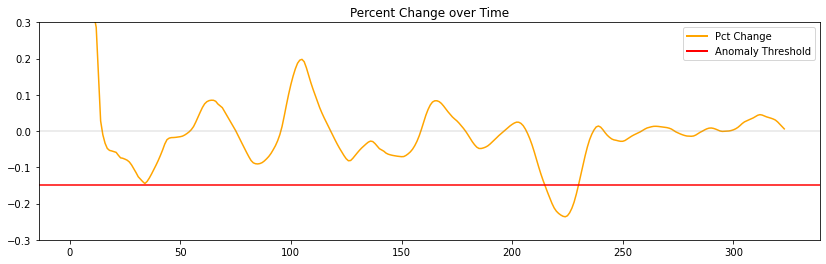

In [ ]:
alpha=0.32

plt.figure(figsize=(14,4))
plt.ylim((-1, 1))
# loss10000to100['pred_loss'].pct_change(2).plot(title='actual percent change', color='blue') # actual
# loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2).plot(color='orange') # rolling mean 
df_['pred_loss_pctc2_smooth'].plot(color='orange', ylim=(-0.3, 0.3), title='Percent Change over Time')
# loss10000to100['pred_loss'].ewm(alpha=alpha, min_periods=1).mean().pct_change(2).plot(color='green') # exp rolling mean
plt.axhline(0, color='grey', alpha=0.2)
plt.axhline(-0.15, color='r')
custom_lines = [Line2D([0], [0], color='orange', lw=2), 
                Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, ['Pct Change', 'Anomaly Threshold'])

<AxesSubplot:>

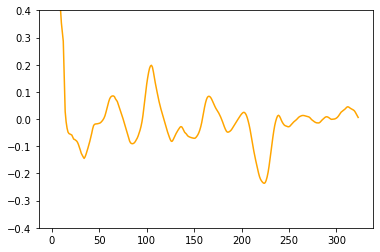

In [ ]:
df_['pred_loss_pctc2_smooth'].plot(color='orange', ylim=(-0.4, 0.4))